In [1]:
import pandas as pd
import numpy as np
import datetime
pd.set_option('display.max_columns', 999)
import pandas.io.sql as psql
# plot a figure directly on Notebook
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

[nltk_data] Downloading package punkt to /Users/kobo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from os.path import exists
data_dir = '/Users/kobo/Documents/aiforhealth/AIForHealth_V-A/data/mimic-iii-clinical-database-1.4'

In [3]:
admissions = pd.read_csv(f'{data_dir}/ADMISSIONS.csv.gz', compression='gzip', low_memory=False)
patients = pd.read_csv(f'{data_dir}/PATIENTS.csv')

print("Admissions Table\t" + str(admissions.shape))
print(admissions.columns)

print("\nPatients Table\t\t" + str(patients.shape))
print(patients.columns)


Admissions Table	(58976, 19)
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

Patients Table		(46520, 8)
Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object')


In [4]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [5]:
admissions.groupby(['ADMISSION_TYPE']).size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
dtype: int64

In [6]:
# convert to dates
admissions.ADMITTIME = pd.to_datetime(admissions.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.DISCHTIME = pd.to_datetime(admissions.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions.DEATHTIME = pd.to_datetime(admissions.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# check to see if there are any missing dates
print('Number of missing date admissions:', admissions.ADMITTIME.isnull().sum())
print('Number of missing date discharges:', admissions.DISCHTIME.isnull().sum())

Number of missing date admissions: 0
Number of missing date discharges: 0


In [7]:
# sort by subject_ID and admission date
admissions = admissions.sort_values(['SUBJECT_ID','ADMITTIME'])
admissions = admissions.reset_index(drop = True)

In [8]:
# verify that it did what we wanted
admissions.loc[admissions.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE
168,124,2165-12-31 18:55:00,EMERGENCY


In [9]:
# add the next admission date and type for each subject using groupby
# you have to use groupby otherwise the dates will be from different subjects
admissions['NEXT_ADMITTIME'] = admissions.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
admissions['NEXT_ADMISSION_TYPE'] = admissions.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [10]:
# verify that it did what we wanted
admissions.loc[admissions.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-05-21 21:02:00,ELECTIVE
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


In [11]:
# get rows where next admission is elective and replace with naT or nan
rows = admissions.NEXT_ADMISSION_TYPE == 'ELECTIVE'
admissions.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
admissions.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [12]:
# verify that it did what we wanted
admissions.loc[admissions.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,NaT,NaN
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


In [13]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill incase something changed the order above
admissions = admissions.sort_values(['SUBJECT_ID','ADMITTIME'])

# back fill (this will take a little while)
admissions[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admissions.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [14]:
# verify that it did what we wanted
admissions.loc[admissions.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]


,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-12-31 18:55:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


In [15]:
# calculate the number of days between discharge and next admission
admissions['DAYS_NEXT_ADMIT']=  (admissions.NEXT_ADMITTIME - admissions.DISCHTIME).dt.total_seconds()/(24*60*60)

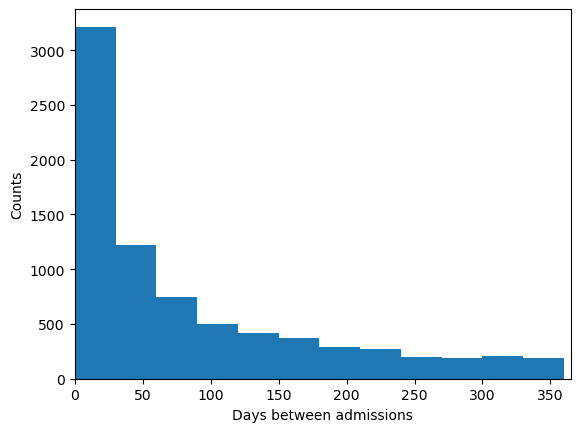

In [16]:
# plot a histogram of days between readmissions if they exist
# this only works for non-null values so you have to filter
plt.hist(admissions.loc[~admissions.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

In [17]:
print('Number with a readmission:', (~admissions.DAYS_NEXT_ADMIT.isnull()).sum())
print('Total Number:', len(admissions))

Number with a readmission: 11399
Total Number: 58976


In [18]:
df_notes = pd.read_csv(f'{data_dir}/NOTEEVENTS.csv')

/var/folders/8g/mc6q7d1x28n5v1v_c5nv73cw0000gn/T/ipykernel_3980/1144765325.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_notes = pd.read_csv(f'{data_dir}/NOTEEVENTS.csv')


In [19]:
print('Number of notes:',len(df_notes))

Number of notes: 2083180


In [20]:
df_notes.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [21]:
# filter to discharge summary
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [22]:
assert df_notes_dis_sum.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'


AssertionError: Multiple discharge summaries per admission

In [23]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'


In [24]:
df_adm_notes = pd.merge(admissions[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(admissions) == len(df_adm_notes), 'Number of rows increased'

In [25]:
print('Fraction of missing notes:', df_adm_notes.TEXT.isnull().sum() / len(df_adm_notes))
print('Fraction notes with newlines:', df_adm_notes.TEXT.str.contains('\n').sum() / len(df_adm_notes))
print('Fraction notes with carriage returns:', df_adm_notes.TEXT.str.contains('\r').sum() / len(df_adm_notes))

Fraction of missing notes: 0.1059753119913185
Fraction notes with newlines: 0.8940246880086815
Fraction notes with carriage returns: 0.0


In [26]:
df_adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()


ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

In [27]:
df_adm_notes_clean = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()


In [28]:
print('Fraction of missing notes:', df_adm_notes_clean.TEXT.isnull().sum() / len(df_adm_notes_clean))
print('Fraction notes with newlines:', df_adm_notes_clean.TEXT.str.contains('\n').sum() / len(df_adm_notes_clean))
print('Fraction notes with carriage returns:', df_adm_notes_clean.TEXT.str.contains('\r').sum() / len(df_adm_notes_clean))

Fraction of missing notes: 0.03971592354195606
Fraction notes with newlines: 0.9602840764580439
Fraction notes with carriage returns: 0.0


In [29]:
df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')


In [30]:
print('Number of positive samples:', (df_adm_notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (df_adm_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes_clean))

Number of positive samples: 3004
Number of negative samples: 48109
Total samples: 51113


In [31]:
# shuffle the samples
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test=df_adm_notes_clean.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all=df_adm_notes_clean.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.OUTPUT_LABEL.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_clean) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 7667): 0.061953828094430674
Valid prevalence(n = 7667): 0.056997521846876224
Train all prevalence(n = 35779): 0.05847005226529529
all samples (n = 51113)


In [32]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

Train prevalence (n = 4184): 0.5


In [33]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [34]:
# preprocess the text to deal with known issues
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

In [35]:
import nltk
from nltk import word_tokenize
word_tokenize('This should be tokenized. 02/02/2018 sentence has stars**')

['This',
 'should',
 'be',
 'tokenized',
 '.',
 '02/02/2018',
 'sentence',
 'has',
 'stars',
 '*',
 '*']

In [36]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [37]:
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [38]:
tokenizer_better('This should be tokenized. 02/02/2018 sentence has stars**')

['this', 'should', 'be', 'tokenized', 'sentence', 'has', 'stars']

In [39]:
sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer = tokenizer_better)
vect.fit(sample_text)

# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)

/Users/kobo/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [41]:
X

<3x10 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [42]:
# we can visualize this small example if we convert it to an array
X.toarray()

array([[1, 0, 2, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0]])

In [43]:
# get the column names
vect.get_feature_names_out()

array(['about', 'amazing', 'data', 'is', 'modeling', 'of', 'part',
       'predictive', 'science', 'the'], dtype=object)

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = tokenizer_better)

# this could take a while
vect.fit(df_train.TEXT.values)

CountVectorizer(max_features=3000,
                tokenizer=<function tokenizer_better at 0x14d2123e0>)

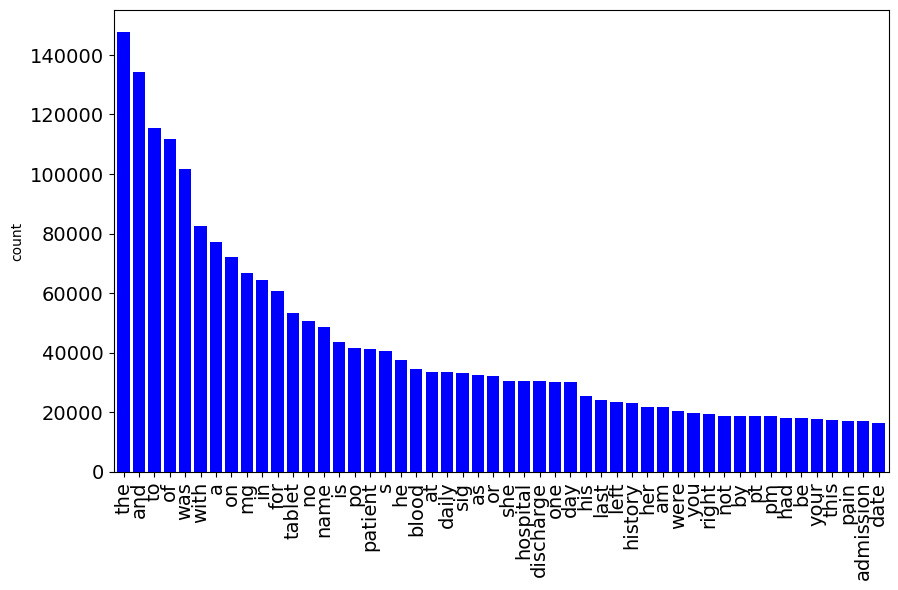

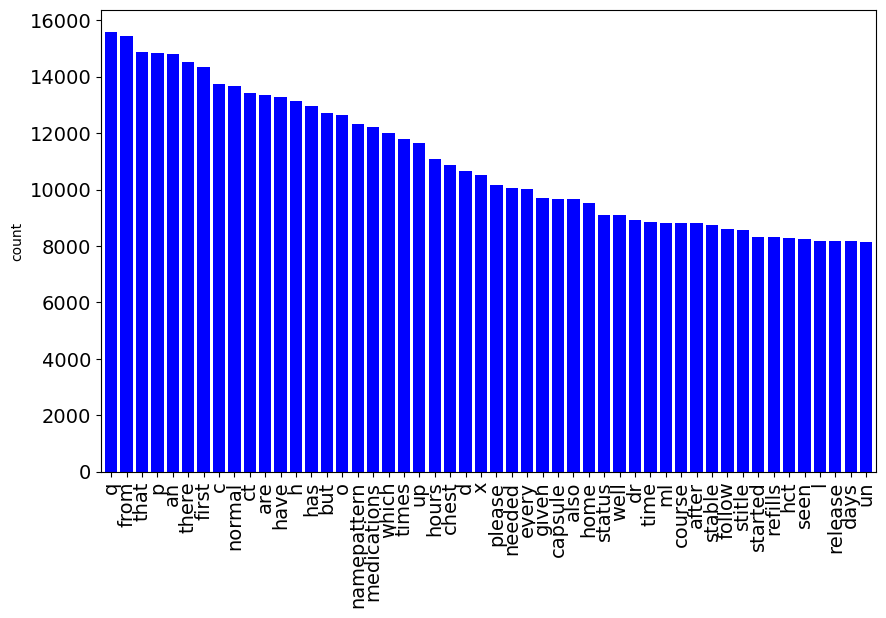

In [45]:
neg_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 0].TEXT)
pos_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names_out()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

#Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [46]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also']

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = tokenizer_better, 
                       stop_words = my_stop_words)
# this could take a while
vect.fit(df_train.TEXT.values)

/Users/kobo/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=3000,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                tokenizer=<function tokenizer_better at 0x14d2123e0>)

In [48]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

In [49]:
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

kNN

In [50]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [52]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)#The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric.
classifier.fit(X_train_tf, y_train)

KNeighborsClassifier()

In [54]:
X_test = vect.transform(df_test.TEXT.values)
y_test = df_test.OUTPUT_LABEL
y_pred = classifier.predict(X_test)

In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[4432 2760]
 [ 217  258]]


0.6117125342376418

In [57]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.metrics import roc_auc_score
model3 = classifier
y_train_preds_knn = model3.predict_proba(X_train_tf)[:,1]
y_valid_preds_knn = model3.predict_proba(X_valid_tf)[:,1]

X_test_knn = vect.transform(df_test.TEXT.values)
y_test_knn = df_test.OUTPUT_LABEL
y_test_preds_knn = model3.predict_proba(X_test_knn)[:,1]

train_acc_knn = np.mean(y_train == (y_train_preds_knn > 0.5))
valid_acc_knn = np.mean(y_valid == (y_valid_preds_knn > 0.5))
test_acc_knn = np.mean(y_test == (y_test_preds_knn > 0.5))
print(train_acc_knn)
print(valid_acc_knn)
print(test_acc_knn)
print(roc_auc_score(y_test_knn, classifier.predict_proba(X_test_knn)[:,1]))


0.7196462715105163
0.6167992695969741
0.6117125342376418
0.6097104970434986


In [61]:

y_train_preds = model3.predict_proba(X_train_tf)[:,1]
y_valid_preds = model3.predict_proba(X_valid_tf)[:,1]
y_test_preds = model3.predict_proba(X_test_knn)[:,1]

In [58]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

Train prevalence(n = 4184): 0.500
Valid prevalence(n = 7667): 0.057
Test prevalence(n = 7667): 0.062
Train AUC:0.801
Valid AUC:0.625
Test AUC:0.610
Train accuracy:0.720
Valid accuracy:0.617
Test accuracy:0.612
Train recall:0.706
Valid recall:0.568
Test recall:0.543
Train precision:0.726
Valid precision:0.083
Test precision:0.085
Train specificity:0.734
Valid specificity:0.620
Test specificity:0.616


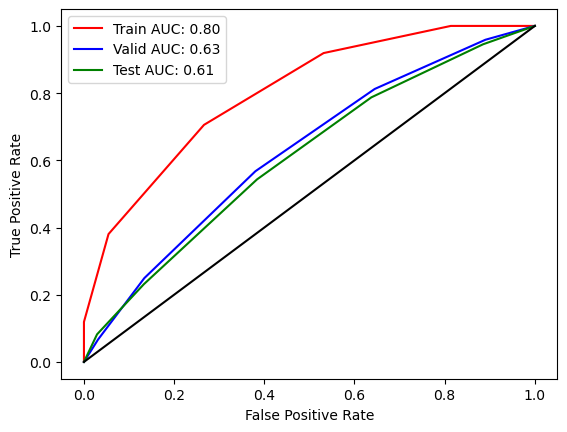

In [62]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train prevalence(n = %d): %.3f'%(len(y_train),sum(y_train)/ len(y_train)))
print('Valid prevalence(n = %d): %.3f'%(len(y_valid),sum(y_valid)/ len(y_valid)))
print('Test prevalence(n = %d): %.3f'%(len(y_test),sum(y_test)/ len(y_test)))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))
print('Test recall:%.3f'%calc_recall(y_test, y_test_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()